# Notebook to generate the plots for the paper - Limbwise analysis

### Getting the data

If you do not already have the data to run this this notebook, you need to
download it from here.



### Standards modules

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy
from scipy import signal
import pathlib
import itertools
import glob
import json
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Custom Modules

In [3]:
sys.path.append("../scripts")

import classification_algorithms as ca
import reduced_models as rm
import task_analysis as ta

import misc
import gmac

In [67]:
# Define the font family and size
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.weight'] = 'light'  # Use 'light' font weight
# plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})


## Define notebook level constants

In [5]:
# Sampling rate for the data is 50ms
dT = 0.02
Fs = int(1 / dT)

In [6]:
# Generate all possible combinations of parameters.
def generate_param_combinations_am(param_ranges: dict) -> dict:
    """
    Generate all possible combinations of parameters.
    """
    for _fc in param_ranges["fc"]:
        for _nc in param_ranges["nc"]:
            for _nam in param_ranges["nam"]:
                yield {
                    "fc": _fc,
                    "nc": int(_nc),
                    "nam": int(_nam)
                }

## Read the Controls and Patients Data

In [7]:
# Read healthy and control data
left, right = misc.read_data(subject_type='control')
aff, unaff = misc.read_data(subject_type='patient')

# Assign segments for each subject
left = pd.concat([misc.assign_segments(left[left.subject == subj], dur_th=1, dT=dT)
                  for subj in left.subject.unique()], axis=0)
right = pd.concat([misc.assign_segments(right[right.subject == subj], dur_th=1, dT=dT)
                   for subj in right.subject.unique()])
aff = pd.concat([misc.assign_segments(aff[aff.subject == subj], dur_th=1, dT=dT)
                 for subj in aff.subject.unique()])
unaff = pd.concat([misc.assign_segments(unaff[unaff.subject == subj], dur_th=1, dT=dT)
                   for subj in unaff.subject.unique()])

# All limbs data ddf
datadf = {
    "left": left,
    "right": right,
    "aff": aff,
    "unaff": unaff
}

## Read the Pitch and Accl. Mag. Estimation files

In [8]:
basedir = "../data/output-r1-full-new"

# Read gmac parameters.
with open(pathlib.Path(basedir, "gmac", "gmac_params.json"), "r") as f:
    gmac_param_ranges = json.load(f)

In [9]:
# Read pitch, gm, and gmac performance file
gmac_perf = pd.read_csv(pathlib.Path(basedir, "gmac", "perf_gmac.csv"))

## Read Subash et 2022 results file

In [10]:
# Read data from Tanya's paper
tempdf = pd.read_csv("../data/subash22data.csv")
del tempdf["Unnamed: 0"]

# Organize data into dictionary
limbsdef = {
    "left": "left",
    "right": "right",
    "aff": "affected",
    "unaff": "unaffected"
}
subash22df = {
    lk: tempdf[tempdf.hand == lv].reset_index(drop=True)
    for lk, lv in limbsdef.items()
}

In [14]:
# Limbs
limbs = ["left", "right", "aff", "unaff"]
subash_perf_gmac = {
    "youden": [],
    "sensitivity": [],
    "specificity": [],
}

model = "GMAC"
for i, limb in enumerate(limbs):
    _inx = (subash22df[limb].method == model)
    subash_perf_gmac["youden"].append(subash22df[limb][_inx]["youden"].values)
    subash_perf_gmac["sensitivity"].append(subash22df[limb][_inx]["sensitivity"].values)
    subash_perf_gmac["specificity"].append(subash22df[limb][_inx]["specificity"].values)

# RF Intersubject
subash_perf_rfinter = {
    "youden": [],
    "sensitivity": [],
    "specificity": [],
}

model = "RF inter"
for i, limb in enumerate(limbs):
    _inx = (subash22df[limb].method == model)
    subash_perf_rfinter["youden"].append(subash22df[limb][_inx]["youden"].values)
    subash_perf_rfinter["sensitivity"].append(subash22df[limb][_inx]["sensitivity"].values)
    subash_perf_rfinter["specificity"].append(subash22df[limb][_inx]["specificity"].values)

# RF Intrasubject
subash_perf_rfintra = {
    "youden": [],
    "sensitivity": [],
    "specificity": [],
}

model = "RF intra"
for i, limb in enumerate(limbs):
    _inx = (subash22df[limb].method == model)
    subash_perf_rfintra["youden"].append(subash22df[limb][_inx]["youden"].values)
    subash_perf_rfintra["sensitivity"].append(subash22df[limb][_inx]["sensitivity"].values)
    subash_perf_rfintra["specificity"].append(subash22df[limb][_inx]["specificity"].values)

# RF Intrasubject mean
subash_perf_rfintra_mean = {
    "youden": [],
    "sensitivity": [],
    "specificity": [],
}

model = "RF intra"
for i, limb in enumerate(limbs):
    _inx = (subash22df[limb].method == model)
    subash_perf_rfintra_mean["youden"].append(subash22df[limb][_inx].groupby("subject")["youden"].mean().values)
    subash_perf_rfintra_mean["sensitivity"].append(subash22df[limb][_inx].groupby("subject")["youden"].mean().values)
    subash_perf_rfintra_mean["specificity"].append(subash22df[limb][_inx].groupby("subject")["youden"].mean().values)

# GMAC Performance: Inter-Subject Limb-wise without validation

In [11]:
# Number of all possible combinations
Ncombs = len(list(misc.generate_param_combinations_gmac(gmac_param_ranges)))

In [29]:
# Generate data for heatmap
# Get performance for the different parameters combinations.
_keys = ["np", "fc", "nc", "nam", "p_th", "p_th_band", "am_th", "am_th_band"]
lens = [len(gmac_param_ranges[_k]) for _k in _keys]
limbs = ["left", "right", "aff", "unaff"]
# Performance data
perf = {_l: np.zeros(lens) for _l in limbs}
med = {_l: np.zeros(lens) for _l in limbs}
iqr = {_l: np.zeros(lens) for _l in limbs}

# Indices for the different parameter combinations
param_combs_enum = list(misc.generate_param_combinations_gmac_wenum(gmac_param_ranges))
pcinx = [
    ((gmac_perf.np == _pcval["np"]) &
     (gmac_perf.fc == _pcval["fc"]) &
     (gmac_perf.nc == _pcval["nc"]) &
     (gmac_perf.nam == _pcval["nam"]) &
     (gmac_perf.am_th == _pcval["am_th"]) &
     (gmac_perf.am_th_band == _pcval["am_th_band"]) &
     (gmac_perf.p_th == _pcval["p_th"]) &
     (gmac_perf.p_th_band == _pcval["p_th_band"]))
    for j, (_ix, _pcval) in enumerate(param_combs_enum)
]

In [33]:
# Limb specific performance
for i, _l in enumerate(limbs):
    # Limb index
    _limbinx = (gmac_perf.limb == _l)
    # All parameter combinations.
    param_combs_enum = list(misc.generate_param_combinations_gmac_wenum(gmac_param_ranges))
    for j, pcvalenum in enumerate(param_combs_enum):
        _ix, _pcval = pcvalenum
        _vals = gmac_perf.loc[_limbinx & pcinx[j].values, "youden"].values
        _ixstr = [f"{k}: {v:2d}" for k, v in _ix.items()]
        sys.stdout.write(f"\r{_l:>6s} {j:6d} {', '.join(_ixstr)}")
        sys.stdout.flush()
        # Computer performance
        _perfs = [np.percentile(_vals, q) for q in [25, 50, 75]]
        _i = tuple(_ix[_k] for _k in _keys)
        perf[_l][_i] = _perfs[1] * (1 - (_perfs[2] - _perfs[0]))
        med[_l][_i] = _perfs[1]
        iqr[_l][_i] = _perfs[2] - _perfs[0]

# Save the perf data as a numpy file
# np.save(pathlib.Path(basedir, "all_perf.npy"), perf)

 unaff  10259 np:  2, fc:  1, nc:  1, nam:  2, p_th: 18, p_th_band:  4, am_th:  2, am_th_band:  0

## Best GMAC parameter for each limb

In [53]:
bestarg = {}
maxinx = {}
for _l in limbs:
    # Maximum performance
    # ["np", "fc", "nc", "nam", "p_th", "p_th_band", "am_th", "am_th_band"]
    _perf = perf[_l][:, :, :, :, :, :, :, :]
    maxperf = np.max(_perf)
    maxinx[_l] = np.where(_perf == maxperf)
    bestarg[_l] = [
        gmac_param_ranges["np"][maxinx[_l][0][0]],
        gmac_param_ranges["fc"][maxinx[_l][1][0]],
        gmac_param_ranges["nc"][maxinx[_l][2][0]],
        gmac_param_ranges["nam"][maxinx[_l][3][0]],
        gmac_param_ranges["p_th"][:][maxinx[_l][4][0]],
        gmac_param_ranges["p_th_band"][maxinx[_l][5][0]],
        gmac_param_ranges["am_th"][maxinx[_l][6][0]],
        gmac_param_ranges["am_th_band"][maxinx[_l][7][0]]
    ]
print(bestarg)

# Save data
with open(pathlib.Path(basedir, "limbwise_bestarg.json"), "w") as f:
    json.dump(bestarg, f, indent=4)

{'left': [50, 0.01, 2, 25, 10, 40, 0.1, 0], 'right': [50, 0.1, 1, 50, 10, 20, 0.1, 0], 'aff': [1, 0.1, 2, 25, 20, 40, 0.1, 0], 'unaff': [1, 0.1, 2, 50, 20, 60, 0.1, 0]}


## Top 5% performance

In [55]:
# Limbwise top 5% performance
# How different is the maximum?
toperfpc = {}
perfinxsort = {}
maxperf = {}
minperf = {}
for _l in limbs:
    # Maximum performance
    maxperf[_l] = np.max(perf[_l])
    minperf[_l] = np.min(perf[_l])
    print(f"{_l:>6s} Max: {maxperf[_l]:.4f}, Min: {minperf[_l]:.4f}")
    _inx = (100 *(perf[_l] - minperf[_l]) / (maxperf[_l] - minperf[_l])) > 95
    perfinx = np.where(_inx)
    topperf = perf[_l][perfinx]
    topperfparam = np.array([
        [
            gmac_param_ranges["np"][perfinx[0][i]],
            gmac_param_ranges["fc"][perfinx[1][i]],
            gmac_param_ranges["nc"][perfinx[2][i]],
            gmac_param_ranges["nam"][perfinx[3][i]],
            gmac_param_ranges["p_th"][:][perfinx[4][i]],
            gmac_param_ranges["p_th_band"][perfinx[5][i]],
            gmac_param_ranges["am_th"][perfinx[6][i]],
            gmac_param_ranges["am_th_band"][perfinx[7][i]],
            topperf[i]
        ]
        for i in range(len(perfinx[0]))
    ])
    # Sort by performance
    _inxpersort = np.argsort(topperf)[::-1]
    topperfparam = topperfparam[_inxpersort, :]
    perfinxsort[_l] = np.array(perfinx).T[_inxpersort, :]
    np.set_printoptions(precision=4, suppress=True)
    toperfpc[_l] = topperfparam.tolist()

print(minperf)
print(maxperf)
print(toperfpc)

# Save data
with open(pathlib.Path(basedir, "limbwise_toperfpc.json"), "w") as f:
    json.dump(toperfpc, f, indent=4)

  left Max: 0.4311, Min: 0.0000
 right Max: 0.5500, Min: -0.0074
   aff Max: 0.4259, Min: -0.0137
 unaff Max: 0.6202, Min: -0.0002
{'left': 0.0, 'right': -0.007376080277552539, 'aff': -0.013697075278694175, 'unaff': -0.00021556131624491954}
{'left': 0.43113163372986935, 'right': 0.5500115593236468, 'aff': 0.4259244892553221, 'unaff': 0.620207251676911}
{'left': [[50.0, 0.01, 2.0, 25.0, 10.0, 40.0, 0.1, 0.0, 0.43113163372986935], [50.0, 0.01, 2.0, 50.0, 10.0, 40.0, 0.1, 0.0, 0.42526956653752673], [50.0, 0.01, 2.0, 1.0, 10.0, 40.0, 0.1, 0.0, 0.42242281791224207], [50.0, 0.01, 2.0, 25.0, 10.0, 60.0, 0.1, 0.0, 0.41016033403881225]], 'right': [[50.0, 0.1, 1.0, 50.0, 10.0, 20.0, 0.1, 0.0, 0.5500115593236468], [50.0, 0.1, 2.0, 50.0, 10.0, 20.0, 0.1, 0.0, 0.5435581338913203], [50.0, 0.1, 1.0, 50.0, 10.0, 40.0, 0.1, 0.0, 0.5417785718584458], [50.0, 0.1, 1.0, 25.0, 10.0, 20.0, 0.1, 0.0, 0.5412852110011691], [25.0, 0.1, 1.0, 25.0, 10.0, 40.0, 0.1, 0.0, 0.5389036259792147], [50.0, 0.1, 2.0, 25.0, 

## Performance Heatmap for the different parameter combinations

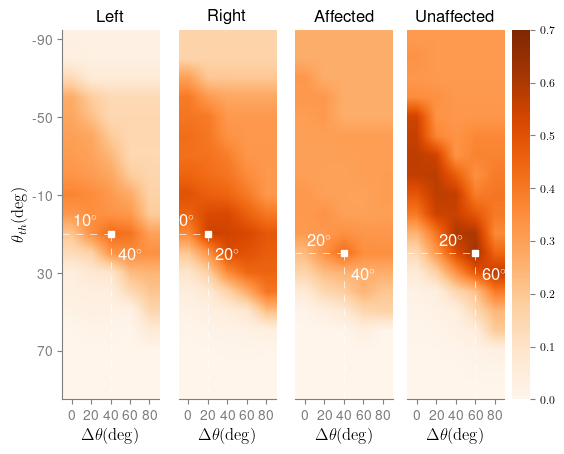

In [79]:
fig = plt.figure()

# Create the heatmap using imshow
limbnames = {
    "left": "Left",
    "right": "Right",
    "aff": "Affected",
    "unaff": "Unaffected"
}
for i, _limb in enumerate(limbs):
    ax = fig.add_subplot(1, 4, i+1)
    maxinx = perfinxsort[_limb][0]
    _hm = ax.imshow(perf[_limb][maxinx[0],
                                maxinx[1],
                                maxinx[2],
                                maxinx[3],
                                :, :,
                                maxinx[6],
                                maxinx[7]],
                    cmap='Oranges', interpolation='bilinear', vmin=0, vmax=0.7)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_color("tab:gray")
    if i == 0:
        ax.set_ylabel(r'$\theta_{th} (\deg)$', fontsize=12)
        ax.set_yticks(np.arange(len(gmac_param_ranges["p_th"])),
                    labels=gmac_param_ranges["p_th"],
                    color="tab:gray")
        ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
        ax.spines["left"].set_visible(True)
        ax.spines["left"].set_color("tab:gray")
        ax.yaxis.set_tick_params(color='tab:grey')
    else:
        ax.set_yticks([])
        ax.spines["left"].set_visible(False)

    # Set x ticks
    ax.set_xticks(np.arange(len(gmac_param_ranges["p_th_band"])),
                    labels=gmac_param_ranges["p_th_band"],
                    color="tab:gray")

    # Add labels to the axes
    ax.set_xlabel(r'$\Delta\theta (\deg)$', fontsize=12)
    ax.xaxis.set_tick_params(color='tab:grey')

    # # Plot the max. point.
    ax.plot(maxinx[5], maxinx[4], 's', color='white', markersize=5)
    ax.plot([maxinx[5], maxinx[5]],
            [maxinx[4], len(gmac_param_ranges["p_th"]) - 0.5], lw=0.5,
            linestyle='dashed', dashes=(10, 10),
            color='white')
    ax.plot([-0.5, maxinx[5]],
            [maxinx[4], maxinx[4]], lw=0.5,
            linestyle='dashed', dashes=(10, 10),
            color='white')
    # Show the max. argument
    ax.text(maxinx[5] - 1.25, maxinx[4] - 0.25,
            (f"{bestarg[_limb][4]:0.0f}" + r"$^\circ$"),
            color='white', ha='center', va='bottom',
            fontsize=12)
    ax.text(maxinx[5] + 1, maxinx[4] + 1.5,
            (f"{bestarg[_limb][5]:0.0f}" + r"$^\circ$"),
            color='white', ha='center', va='bottom',
            fontsize=12)
    ax.set_title(f"{limbnames[_limb]}", fontsize=12)

# # Color map
_cbar = plt.colorbar(_hm)
# Modify colorbar settings
_cbar.ax.tick_params(labelsize=8)  # Set tick label font size
_cbar.set_alpha(0.7)  # Set colorbar opacity (alpha value)
_cbar.outline.set_linewidth(0.)  # Set the colorbar outline thickness
_cbar.ax.yaxis.set_tick_params(color='tab:gray')

plt.subplots_adjust(wspace=-0.2)

# Save plot
fig.savefig(pathlib.Path(basedir, "limbwise_gmac_perf_hm.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "limbwise_gmac_perf_hm.svg"), bbox_inches="tight")

## Extra plots

### Range of Youden Index for different limbs

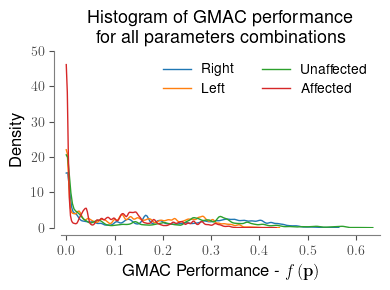

In [94]:
# All possible Younden index, Sensitivity, and Specificity
fig = plt.figure(figsize=(4, 3))

# Histrogram of all Younden indices
ax = fig.add_subplot(111)
sns.kdeplot(data=perf["right"].flatten(), bw_adjust=0.2, clip=[0, 1], lw=1,
            ax=ax, label="Right")
sns.kdeplot(data=perf["left"].flatten(), bw_adjust=0.2, clip=[0, 1], lw=1,
            ax=ax, label="Left")
sns.kdeplot(data=perf["unaff"].flatten(), bw_adjust=0.2, clip=[0, 1], lw=1,
            ax=ax, label="Unaffected")
sns.kdeplot(data=perf["aff"].flatten(), bw_adjust=0.2, clip=[0, 1], lw=1,
            ax=ax, label="Affected")
ax.set_xlim(-0.01, 0.65)
ax.set_ylim(-0.2, 50)
ax.legend(loc=1, frameon=False, fontsize=10, ncol=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.set_ylabel("Density", fontsize=12)
ax.set_xlabel(r"GMAC Performance - $f\left(\mathbf{p}\right)$", fontsize=12)
ax.set_title("Histogram of GMAC performance\nfor all parameters combinations", fontsize=13)

plt.tight_layout()

# Save plot
fig.savefig(pathlib.Path(basedir, "limbwise_all_gmacperf_hist.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "limbwise_all_gmacperf_hist.svg"), bbox_inches="tight")

# All Subject Inter-subject GMAC Model with validation (Leave-One-Subject)

In [96]:
# Add a healthy / stroke subject column
_subjtype = [
    f"H{_row[1]['subject']}" if _row[1]["limb"] in ["left", "right"]
    else f"S{_row[1]['subject']}"
    for i, _row in enumerate(gmac_perf[["subject", "limb"]].iterrows())
]
gmac_perf["subjtype"] = _subjtype
gmac_perf

,subject,np,fc,nc,nam,p_th,p_th_band,am_th,am_th_band,limb,...,FN,TP,TNr,FPr,FNr,TPr,sensitivity,specificity,youden,subjtype
0,2,1,0.01,1,1,-90,0,0.00,0,left,...,0,17133,0.000082,0.293752,0.000000,0.706166,1.000000,0.000281,0.000281,H2
1,2,1,0.01,1,1,-90,0,0.10,0,left,...,2291,14842,0.025142,0.268692,0.094427,0.611739,0.866281,0.085566,-0.048153,H2
2,2,1,0.01,1,1,-90,0,0.25,0,left,...,6797,10336,0.130904,0.162930,0.280150,0.426016,0.603280,0.445504,0.048784,H2
3,2,1,0.01,1,1,-90,20,0.00,0,left,...,0,17133,0.000082,0.293752,0.000000,0.706166,1.000000,0.000281,0.000281,H2
4,2,1,0.01,1,1,-90,20,0.10,0,left,...,2291,14842,0.025142,0.268692,0.094427,0.611739,0.866281,0.085566,-0.048153,H2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307795,5,50,0.10,2,50,90,60,0.10,0,unaff,...,15134,0,0.381301,0.000000,0.618699,0.000000,0.000000,1.000000,0.000000,S5
307796,5,50,0.10,2,50,90,60,0.25,0,unaff,...,15134,0,0.381301,0.000000,0.618699,0.000000,0.000000,1.000000,0.000000,S5
307797,5,50,0.10,2,50,90,80,0.00,0,unaff,...,15134,0,0.381301,0.000000,0.618699,0.000000,0.000000,1.000000,0.000000,S5
307798,5,50,0.10,2,50,90,80,0.10,0,unaff,...,15134,0,0.381301,0.000000,0.618699,0.000000,0.000000,1.000000,0.000000,S5


In [97]:
# Indices for the different parameter combinations
param_combs_enum = list(misc.generate_param_combinations_gmac_wenum(gmac_param_ranges))
pcinx = [
    ((gmac_perf.np == _pcval["np"]) &
     (gmac_perf.fc == _pcval["fc"]) &
     (gmac_perf.nc == _pcval["nc"]) &
     (gmac_perf.nam == _pcval["nam"]) &
     (gmac_perf.am_th == _pcval["am_th"]) &
     (gmac_perf.am_th_band == _pcval["am_th_band"]) &
     (gmac_perf.p_th == _pcval["p_th"]) &
     (gmac_perf.p_th_band == _pcval["p_th_band"]))
    for j, (_ix, _pcval) in enumerate(param_combs_enum)
]

In [139]:
# Get performance for the different parameters combinations.
_keys = ["np", "fc", "nc", "nam", "p_th", "p_th_band", "am_th", "am_th_band"]
# lens = [len(gmac_param_ranges[_k]) for _k in _keys]
perf_loso = {}
med_loso = {}
iqr_loso = {}
subjs_loso = {}
# Go through the four limbs and perform LOSO
for _il, _lmb in enumerate(limbs):
    # Limb index.
    _limbinx = (gmac_perf.limb == _lmb)
    # Find the subjects
    subjs_loso[_lmb] = list(set(gmac_perf[_limbinx].subjtype))
    # Initialize performance variables
    _lens = [len(subjs_loso[_lmb])] + [len(gmac_param_ranges[_k]) for _k in _keys]
    perf_loso[_lmb] = np.zeros(_lens)
    med_loso[_lmb] = np.zeros(_lens)
    iqr_loso[_lmb] = np.zeros(_lens)
    # Go through the subjects and leave them out.
    for _is, _subj in enumerate(subjs_loso[_lmb]):
        # Index to leave out.
        _losoinx = ~(gmac_perf.subjtype == _subj)
        # Find the performance based on the other subjects
        param_combs_enum = list(misc.generate_param_combinations_gmac_wenum(gmac_param_ranges))
        for _ip, pcvalenum in enumerate(param_combs_enum):
            _ix, _pcval = pcvalenum
            _vals = gmac_perf.loc[_limbinx & _losoinx & pcinx[_ip].values, "youden"].values
            _ixstr = [f"{k}: {v:2d}" for k, v in _ix.items()]
            sys.stdout.write(f"\r{_lmb:>6s} {_is:3d} {_subj:>3s} {_ip:6d} {', '.join(_ixstr)}")
            sys.stdout.flush()
            # Computer performance
            _perfs = [np.percentile(_vals, q) for q in [25, 50, 75]]
            _i = tuple([_is]) + tuple(_ix[_k] for _k in _keys)
            perf_loso[_lmb][_i] = _perfs[1] * (1 - (_perfs[2] - _perfs[0]))
            med_loso[_lmb][_i] = _perfs[1]
            iqr_loso[_lmb][_i] = _perfs[2] - _perfs[0]

 unaff   4  S3  10259 np:  2, fc:  1, nc:  1, nam:  2, p_th: 18, p_th_band:  4, am_th:  2, am_th_band:  0

## Find the best args for each left out subject

In [144]:
bestargs = {}
for _lmb in limbs:
    maxinx = {subjs_loso[_lmb][i]: np.array(np.where(_perf == np.max(_perf))).T[0]
              for i, _perf in enumerate(perf_loso[_lmb])}
    bestargs[_lmb] = {
        _k: [
            gmac_param_ranges["np"][_mx[0]],
            gmac_param_ranges["fc"][_mx[1]],
            gmac_param_ranges["nc"][_mx[2]],
            gmac_param_ranges["nam"][_mx[3]],
            gmac_param_ranges["p_th"][_mx[4]],
            gmac_param_ranges["p_th_band"][_mx[5]],
            gmac_param_ranges["am_th"][_mx[6]],
            gmac_param_ranges["am_th_band"][_mx[7]]
        ] for _k, _mx in maxinx.items()
    }
bestargs

{'left': {'H1': [50, 0.01, 2, 50, 10, 40, 0.1, 0],
  'H8': [50, 0.01, 2, 25, 10, 40, 0.1, 0],
  'H3': [50, 0.01, 2, 25, 10, 40, 0.1, 0],
  'H9': [50, 0.01, 2, 25, 10, 40, 0.1, 0],
  'H2': [50, 0.01, 2, 25, 10, 40, 0.1, 0],
  'H5': [50, 0.01, 2, 25, 10, 40, 0.1, 0],
  'H7': [50, 0.01, 2, 50, 10, 40, 0.1, 0],
  'H10': [50, 0.01, 2, 25, 10, 40, 0.1, 0],
  'H6': [50, 0.01, 2, 25, 10, 40, 0.1, 0],
  'H4': [50, 0.01, 2, 50, 10, 40, 0.1, 0]},
 'right': {'H1': [50, 0.1, 1, 25, 10, 40, 0.1, 0],
  'H8': [25, 0.01, 2, 25, 10, 20, 0.1, 0],
  'H3': [25, 0.1, 1, 25, 10, 40, 0.1, 0],
  'H9': [50, 0.1, 1, 50, 10, 20, 0.1, 0],
  'H2': [50, 0.1, 1, 50, 10, 20, 0.1, 0],
  'H5': [50, 0.1, 1, 50, 10, 20, 0.1, 0],
  'H7': [50, 0.1, 2, 50, 10, 20, 0.1, 0],
  'H10': [50, 0.1, 2, 50, 10, 20, 0.1, 0],
  'H6': [50, 0.1, 2, 50, 10, 20, 0.1, 0],
  'H4': [50, 0.1, 1, 50, 10, 20, 0.1, 0]},
 'aff': {'S4': [1, 0.1, 2, 25, 20, 40, 0.1, 0],
  'S5': [1, 0.1, 2, 25, 20, 40, 0.1, 0],
  'S2': [1, 0.1, 2, 50, 20, 40, 0.1, 0]

#### LOSO Performance Dataframe

In [236]:
cols = ["subj", "subjid", "limb", "method",
        "youden", "sensitivity", "specificity"]
losoperfdf = pd.DataFrame(columns=cols)

# Go through each limb
for _lmb in limbs:
    sys.stdout.write(f">{_lmb}")
    for _subj in subjs_loso[_lmb]:
        sys.stdout.write(f" {_subj}")
        sys.stdout.flush()
        _losoinx = (gmac_perf.subjtype == _subj)
        _limbinx = (gmac_perf.limb == _lmb)
        _inx = ((gmac_perf.np == bestargs[_lmb][_subj][0]) &
                (gmac_perf.fc == bestargs[_lmb][_subj][1]) &
                (gmac_perf.nc == bestargs[_lmb][_subj][2]) &
                (gmac_perf.nam == bestargs[_lmb][_subj][3]) &
                (gmac_perf.p_th == bestargs[_lmb][_subj][4]) &
                (gmac_perf.p_th_band == bestargs[_lmb][_subj][5]) &
                (gmac_perf.am_th == bestargs[_lmb][_subj][6]) &
                (gmac_perf.am_th_band == bestargs[_lmb][_subj][7]))
        # New row df
        _newrowdf = pd.DataFrame.from_dict({
            "subj": [_subj],
            "limb": [_lmb],
            "subjid": gmac_perf[_losoinx].subject.unique(),
            "method": ["GMAC"],
            "youden": gmac_perf[_losoinx & _limbinx & _inx].youden,
            "sensitivity": gmac_perf[_losoinx & _limbinx & _inx].sensitivity,
            "specificity": gmac_perf[_losoinx & _limbinx & _inx].specificity
        })
        losoperfdf = pd.concat([losoperfdf, _newrowdf], ignore_index=True)
    sys.stdout.write("\n")
losoperfdf

>left H1 H8 H3 H9 H2 H5 H7 H10 H6 H4
>right H1 H8 H3 H9 H2 H5 H7 H10 H6 H4
>aff S4 S5 S2 S1 S3
>unaff S4 S5 S2 S1 S3


,subj,subjid,limb,method,youden,sensitivity,specificity
0,H1,1,left,GMAC,0.331523,0.858885,0.472638
1,H8,8,left,GMAC,0.499860,0.842563,0.657297
2,H3,3,left,GMAC,0.464229,0.920748,0.543481
3,H9,9,left,GMAC,0.764873,0.872587,0.892287
4,H2,2,left,GMAC,0.454915,0.905329,0.549586
5,H5,5,left,GMAC,0.511684,0.900483,0.611201
6,H7,7,left,GMAC,0.317466,0.834563,0.482904
7,H10,10,left,GMAC,0.463870,0.911817,0.552053
8,H6,6,left,GMAC,0.496272,0.715676,0.780596
9,H4,4,left,GMAC,0.414736,0.925460,0.489275


### Now add results from Subash et al. 2022

In [237]:
# Go through each limb
for _lmb in limbs:
    sys.stdout.write(f">{_lmb}")
    for _subj in subjs_loso[_lmb]:
        sys.stdout.write(f" {_subj}")
        sys.stdout.flush()
        _subjid = gmac_perf[gmac_perf.subjtype == _subj]["subject"].unique()[0]
        #
        # # Old GMAC
        _minx = subash22df[_lmb].method == "GMAC"
        _sinx = (subash22df[_lmb]["subject"] == _subjid)
        _tempdf = subash22df[_lmb][_minx & _sinx]
        # New row df
        _newrowdf = pd.DataFrame.from_dict({
            "subj": [_subj],
            "limb": [_lmb],
            "subjid": [_subjid],
            "method": ["OldGMAC"],
            "youden": _tempdf.youden,
            "sensitivity": _tempdf.sensitivity,
            "specificity": _tempdf.specificity
        })
        losoperfdf = pd.concat([losoperfdf, _newrowdf], ignore_index=True)
        #
        # # RF Inter
        _minx = subash22df[_lmb].method == "RF inter"
        _tempdf = subash22df[_lmb][_minx & _sinx]
        # New row df
        _newrowdf = pd.DataFrame.from_dict({
            "subj": [_subj],
            "limb": [_lmb],
            "subjid": [_subjid],
            "method": ["RFinter"],
            "youden": _tempdf.youden,
            "sensitivity": _tempdf.sensitivity,
            "specificity": _tempdf.specificity
        })
        losoperfdf = pd.concat([losoperfdf, _newrowdf], ignore_index=True)
        #
        # # RF Inter
        _minx = subash22df[_lmb].method == "RF intra"
        _tempdf = subash22df[_lmb][_minx & _sinx]
        # New row df
        # Raw
        _N = len(_tempdf.youden.values)
        _newrowdf = pd.DataFrame.from_dict({
            "subj": [_subj] * _N,
            "limb": [_lmb] * _N,
            "subjid": [_subjid] * _N,
            "method": ["RFintra"] * _N,
            "youden": _tempdf.youden.values,
            "sensitivity": _tempdf.sensitivity.values,
            "specificity": _tempdf.specificity.values
        })
        losoperfdf = pd.concat([losoperfdf, _newrowdf], ignore_index=True)
        # Mean
        _newrowdf = pd.DataFrame.from_dict({
            "subj": [_subj],
            "limb": [_lmb],
            "subjid": [_subjid],
            "method": ["RFintramean"],
            "youden": np.nanmean(_tempdf.youden.values),
            "sensitivity": np.nanmean(_tempdf.sensitivity.values),
            "specificity": np.nanmean(_tempdf.specificity.values)
        })
        losoperfdf = pd.concat([losoperfdf, _newrowdf], ignore_index=True)
    sys.stdout.write("\n")
losoperfdf.to_csv(f"{basedir}/limbwise_losoperfdf.csv")
losoperfdf

>left H1 H8 H3 H9 H2 H5 H7 H10 H6 H4
>right H1 H8 H3 H9 H2 H5 H7 H10 H6 H4
>aff S4 S5 S2 S1 S3
>unaff S4 S5 S2 S1 S3


,subj,subjid,limb,method,youden,sensitivity,specificity
0,H1,1,left,GMAC,0.331523,0.858885,0.472638
1,H8,8,left,GMAC,0.499860,0.842563,0.657297
2,H3,3,left,GMAC,0.464229,0.920748,0.543481
3,H9,9,left,GMAC,0.764873,0.872587,0.892287
4,H2,2,left,GMAC,0.454915,0.905329,0.549586
...,...,...,...,...,...,...,...
415,S3,3,unaff,RFintra,0.842105,1.000000,0.842105
416,S3,3,unaff,RFintra,0.739583,0.906250,0.833333
417,S3,3,unaff,RFintra,0.882184,0.965517,0.916667
418,S3,3,unaff,RFintra,0.842105,1.000000,0.842105


### Comparing performance with Subash et al. 2022 (means, CIs)

In [196]:
def compute_bootstrap_mean_ci(rawdata, n_bootstrap_samples=1000):
    # Find the bootstrap means and CIs.
    bootstrap_means = np.zeros(n_bootstrap_samples)
    for i in range(n_bootstrap_samples):
        bootstrap_sample = np.random.choice(rawdata, size=len(rawdata), replace=True)
        bootstrap_means[i] = np.mean(bootstrap_sample)
    return (np.nanmean(bootstrap_means),
            np.nanpercentile(bootstrap_means, [2.5, 97.5]))

In [206]:
# compute_bootstrap_mean_ci(losoperf["youden"])
print(compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "GMAC"]["youden"]))
print(compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "OldGMAC"]["youden"]))
print(compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "RFinter"]["youden"]))
print(compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "RFintra"]["youden"]))

(0.503595512406635, array([0.4592, 0.5501]))
(0.33454862449443334, array([0.2811, 0.3971]))
(0.47403742226653334, array([0.4203, 0.5293]))
(0.7163228119460603, array([0.6656, 0.7599]))


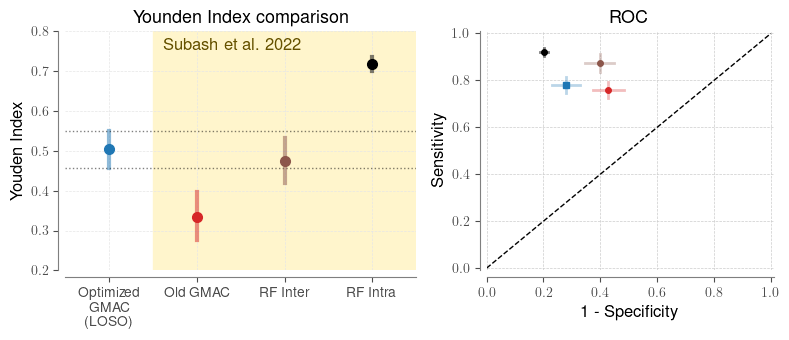

In [223]:
# Combine data from all limbs
lightc = ["#f08181", "#72a3f2", "#ffaf69", "#d2a679", "#ababab", "#b2b266", "#b2b266"]
# darkc = ["#a80a0a", "#002eab", "#bd6e00", "#86592d", "black", "#55552b", "#55552b"]
darkc = ["#a80a0a", "tab:blue", "tab:red", "tab:brown", "black", "#55552b", "#55552b"]
darkc_dict = {f"{i}": c for i, c in enumerate(darkc)}
fig = plt.figure(figsize=(8, 3.5))
gs = gridspec.GridSpec(1, 2, height_ratios=[1], width_ratios=[4.4, 3.6])

# Number of bootstrap samples
means = {}
ci95 = {}
# Find the bootstrap means and CIs.
means["newgmac"], ci95["newgmac"] = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "GMAC"]["youden"])
means["oldgmac"], ci95["oldgmac"] = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "OldGMAC"]["youden"])
means["rfinter"], ci95["rfinter"] = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "RFinter"]["youden"])
means["rfintra"], ci95["rfintra"] = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "RFintra"]["youden"])

ax = plt.subplot(gs[0, 0])
# Current performance
j = 1
ax.plot([j-0.], [means["newgmac"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["newgmac"], color=darkc[j], lw=3, alpha=0.5)
ax.axhline(ci95["newgmac"][0], color="black", alpha=0.5, lw=1, ls="dotted")
ax.axhline(ci95["newgmac"][1], color="black", alpha=0.5, lw=1, ls="dotted")
j = 2
ax.plot([j-0.], [means["oldgmac"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["oldgmac"], color=darkc[j], lw=3, alpha=0.5)
j = 3
ax.plot([j-0.], [means["rfinter"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["rfinter"], color=darkc[j], lw=3, alpha=0.5)
j = 4
ax.plot([j-0.], [means["rfintra"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["rfintra"], color=darkc[j], lw=3, alpha=0.5)

# Backgrounds
background = plt.Rectangle((0.25, 0), 1, 1,
                           transform=ax.transAxes,
                           color='#fff5cc', zorder=-1)
ax.add_patch(background)
ax.text(0.28, 0.97, "Subash et al. 2022", ha="left", va="top", fontsize=12,
        color="#665200", transform=ax.transAxes,)

ax.set_ylim(0.2, 0.8)
ax.set_xlim(0.5, 4.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.9', linestyle='--', linewidth=0.5);
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(
    ["Optimized\nGMAC\n(LOSO)",] +
    ["Old GMAC", "RF Inter", "RF Intra"],
)
ax.set_ylabel("Youden Index", fontsize=12)
ax.set_title("Younden Index comparison", fontsize=13)

# ROC plot
ax = plt.subplot(gs[0, 1])
ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
# LOSO Optimized GMAC
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "GMAC"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "GMAC"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[1], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[1], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color=darkc[1], alpha=1)

# Old GMAC
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "OldGMAC"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "OldGMAC"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[2], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[2], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[2], alpha=1)

# RF Inter
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "RFinter"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "RFinter"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[3], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[3], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[3], alpha=1)

# RF Intra
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "RFintra"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "RFintra"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[4], alpha=0.5, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[4], alpha=0.5, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[4], alpha=1)

ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("ROC", fontsize=13)

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, f"limbwise_gmac_summary_all_loso.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, f"limbwise_gmac_summary_all_loso.svg"), bbox_inches="tight")

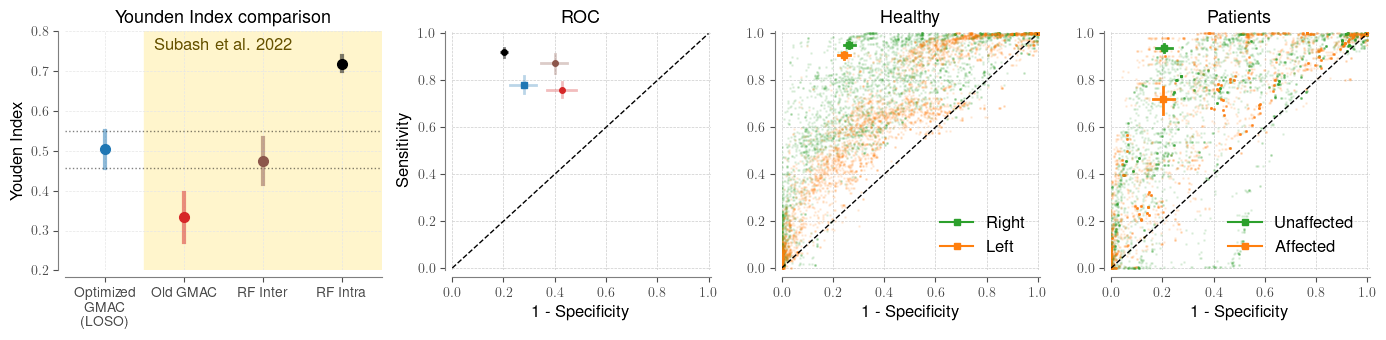

In [235]:
# Combine data from all limbs
lightc = ["#f08181", "#72a3f2", "#ffaf69", "#d2a679", "#ababab", "#b2b266", "#b2b266"]
# darkc = ["#a80a0a", "#002eab", "#bd6e00", "#86592d", "black", "#55552b", "#55552b"]
darkc = ["#a80a0a", "tab:blue", "tab:red", "tab:brown", "black", "#55552b", "#55552b"]
darkc_dict = {f"{i}": c for i, c in enumerate(darkc)}
fig = plt.figure(figsize=(14, 3.5))
gs = gridspec.GridSpec(1, 4, height_ratios=[1], width_ratios=[4.4, 3.6, 3.6, 3.6])

# Number of bootstrap samples
means = {}
ci95 = {}
# Find the bootstrap means and CIs.
means["newgmac"], ci95["newgmac"] = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "GMAC"]["youden"])
means["oldgmac"], ci95["oldgmac"] = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "OldGMAC"]["youden"])
means["rfinter"], ci95["rfinter"] = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "RFinter"]["youden"])
means["rfintra"], ci95["rfintra"] = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "RFintra"]["youden"])

ax = plt.subplot(gs[0, 0])
# Current performance
j = 1
ax.plot([j-0.], [means["newgmac"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["newgmac"], color=darkc[j], lw=3, alpha=0.5)
ax.axhline(ci95["newgmac"][0], color="black", alpha=0.5, lw=1, ls="dotted")
ax.axhline(ci95["newgmac"][1], color="black", alpha=0.5, lw=1, ls="dotted")
j = 2
ax.plot([j-0.], [means["oldgmac"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["oldgmac"], color=darkc[j], lw=3, alpha=0.5)
j = 3
ax.plot([j-0.], [means["rfinter"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["rfinter"], color=darkc[j], lw=3, alpha=0.5)
j = 4
ax.plot([j-0.], [means["rfintra"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["rfintra"], color=darkc[j], lw=3, alpha=0.5)

# Backgrounds
background = plt.Rectangle((0.25, 0), 1, 1,
                           transform=ax.transAxes,
                           color='#fff5cc', zorder=-1)
ax.add_patch(background)
ax.text(0.28, 0.97, "Subash et al. 2022", ha="left", va="top", fontsize=12,
        color="#665200", transform=ax.transAxes,)

ax.set_ylim(0.2, 0.8)
ax.set_xlim(0.5, 4.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.9', linestyle='--', linewidth=0.5);
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(
    ["Optimized\nGMAC\n(LOSO)",] +
    ["Old GMAC", "RF Inter", "RF Intra"],
)
ax.set_ylabel("Youden Index", fontsize=12)
ax.set_title("Younden Index comparison", fontsize=13)

# ROC plot
ax = plt.subplot(gs[0, 1])
ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
# LOSO Optimized GMAC
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "GMAC"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "GMAC"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[1], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[1], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color=darkc[1], alpha=1)

# Old GMAC
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "OldGMAC"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "OldGMAC"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[2], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[2], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[2], alpha=1)

# RF Inter
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "RFinter"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "RFinter"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[3], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[3], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[3], alpha=1)

# RF Intra
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "RFintra"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["method"] == "RFintra"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[4], alpha=0.5, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[4], alpha=0.5, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[4], alpha=1)

ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("ROC", fontsize=13)

ax = plt.subplot(gs[0, 2])
# Get Sens, and Spec.
# Number of bootstrap samples
means = {}
ci95 = {}

# Find the bootstrap means and CIs.
# Right Limb
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["limb"] == "right"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["limb"] == "right"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:green", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:green", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:green", alpha=1, label="Right")

# spec, sens vals
limb_inx = (gmac_perf["limb"] == "right")
N = np.sum(limb_inx)
_randinx = np.random.choice(N, 5000, replace=False)
_spec = 1 - gmac_perf[limb_inx]["specificity"].values
_sens = gmac_perf[limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:green", marker=".", markersize=2,
        alpha=0.1, linestyle="None")

# Left Limb
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["limb"] == "left"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["limb"] == "left"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:orange", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:orange", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:orange", alpha=1, label="Left")

# spec, sens vals
limb_inx = (gmac_perf["limb"] == "left")
N = np.sum(limb_inx)
_randinx = np.random.choice(N, 5000, replace=False)
_spec = 1 - gmac_perf[limb_inx]["specificity"].values
_sens = gmac_perf[limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:orange", marker=".", markersize=2,
        alpha=0.1, linestyle="None")

ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
# ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.legend(loc=4, frameon=False, fontsize=12)
ax.set_title("Healthy", fontsize=13)

ax = plt.subplot(gs[0, 3])
# Unaffected Limb
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["limb"] == "unaff"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["limb"] == "unaff"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:green", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:green", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:green", alpha=1, label="Unaffected")

# spec, sens vals
limb_inx = (gmac_perf["limb"] == "unaff")
N = np.sum( limb_inx)
_randinx = np.random.choice(N, 5000, replace=False)
_spec = 1 - gmac_perf[ limb_inx]["specificity"].values
_sens = gmac_perf[ limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:green", marker=".", markersize=2,
        alpha=0.1, linestyle="None")

# Left Limb
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["limb"] == "aff"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[losoperfdf["limb"] == "aff"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:orange", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:orange", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:orange", alpha=1, label="Affected")

# spec, sens vals
limb_inx = (gmac_perf["limb"] == "aff")
N = np.sum( limb_inx)
_randinx = np.random.choice(N, 5000, replace=False)
_spec = 1 - gmac_perf[ limb_inx]["specificity"].values
_sens = gmac_perf[ limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:orange", marker=".", markersize=2,
        alpha=0.1, linestyle="None")

ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.legend(loc=4, frameon=False, fontsize=12)
ax.set_title("Patients", fontsize=13)

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, f"limbwise_gmac_summary_all_loso_roc.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, f"limbwise_gmac_summary_all_loso_roc.svg"), bbox_inches="tight")

### LME model of performance

In [239]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

### Pairwise comparison

#### All subjects

In [273]:
# Methods index
gmacinx = losoperfdf["method"] == "GMAC"
oldgmacinx = losoperfdf["method"] == "OldGMAC"
rfinterinx = losoperfdf["method"] == "RFinter"
rfintrainx = losoperfdf["method"] == "RFintramean"

In [274]:
outcome = "youden"

# GMAC vs. Old GMAC
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[gmacinx][outcome].values,
    losoperfdf[oldgmacinx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05 / 3
print(f"[Old GMAC], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[gmacinx][outcome].values
         - losoperfdf[oldgmacinx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf inter
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[gmacinx][outcome].values,
    losoperfdf[rfinterinx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF inter], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[gmacinx][outcome].values
         - losoperfdf[rfinterinx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf intra
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[gmacinx][outcome].values,
    losoperfdf[rfintrainx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF intra], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[gmacinx][outcome].values
         - losoperfdf[rfintrainx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

[Old GMAC], youden
0.000
0.170 $\pm$ 0.117

[RF inter], youden
Not significant
0.029 $\pm$ 0.131

[RF intra], youden
0.000
-0.213 $\pm$ 0.165


In [275]:
outcome = "sensitivity"

# GMAC vs. Old GMAC
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[gmacinx][outcome].values,
    losoperfdf[oldgmacinx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05 / 3
print(f"[Old GMAC], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[gmacinx][outcome].values
         - losoperfdf[oldgmacinx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf inter
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[gmacinx][outcome].values,
    losoperfdf[rfinterinx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF inter], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[gmacinx][outcome].values
         - losoperfdf[rfinterinx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf intra
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[gmacinx][outcome].values,
    losoperfdf[rfintrainx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF intra], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[gmacinx][outcome].values
         - losoperfdf[rfintrainx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

[Old GMAC], sensitivity
Not significant
0.021 $\pm$ 0.168

[RF inter], sensitivity
0.002
-0.093 $\pm$ 0.146

[RF intra], sensitivity
0.000
-0.137 $\pm$ 0.171


In [276]:
outcome = "specificity"

# GMAC vs. Old GMAC
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[gmacinx][outcome].values,
    losoperfdf[oldgmacinx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05 / 3
print(f"[Old GMAC], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[gmacinx][outcome].values
         - losoperfdf[oldgmacinx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf inter
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[gmacinx][outcome].values,
    losoperfdf[rfinterinx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF inter], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[gmacinx][outcome].values
         - losoperfdf[rfinterinx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf intra
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[gmacinx][outcome].values,
    losoperfdf[rfintrainx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF intra], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[gmacinx][outcome].values
         - losoperfdf[rfintrainx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

[Old GMAC], specificity
0.000
0.148 $\pm$ 0.152

[RF inter], specificity
0.000
0.121 $\pm$ 0.126

[RF intra], specificity
0.008
-0.076 $\pm$ 0.145


#### Healthy or Hemiparetic Participants

In [286]:
# stype = "Healthy"
# limbinx = ((losoperfdf["limb"] == "right") |
#            (losoperfdf["limb"] == "left"))
stype = "Patients"
limbinx= ((losoperfdf["limb"] == "uaff") |
          (losoperfdf["limb"] == "aff"))

In [287]:
outcome = "youden"
print(stype)

# GMAC vs. Old GMAC
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[limbinx & gmacinx][outcome].values,
    losoperfdf[limbinx & oldgmacinx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05 / 3
print(f"[Old GMAC], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[limbinx & gmacinx][outcome].values
         - losoperfdf[limbinx & oldgmacinx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf inter
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[limbinx & gmacinx][outcome].values,
    losoperfdf[limbinx & rfinterinx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF inter], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[limbinx & gmacinx][outcome].values
         - losoperfdf[limbinx & rfinterinx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf intra
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[limbinx & gmacinx][outcome].values,
    losoperfdf[limbinx & rfintrainx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF intra], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[limbinx & gmacinx][outcome].values
         - losoperfdf[limbinx & rfintrainx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

Patients
[Old GMAC], youden
0.006
0.196 $\pm$ 0.073

[RF inter], youden
Not significant
0.042 $\pm$ 0.165

[RF intra], youden
Not significant
-0.136 $\pm$ 0.328


In [288]:
outcome = "sensitivity"
print(stype)

# GMAC vs. Old GMAC
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[limbinx & gmacinx][outcome].values,
    losoperfdf[limbinx & oldgmacinx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05 / 3
print(f"[Old GMAC], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[limbinx & gmacinx][outcome].values
         - losoperfdf[limbinx & oldgmacinx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf inter
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[limbinx & gmacinx][outcome].values,
    losoperfdf[limbinx & rfinterinx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF inter], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[limbinx & gmacinx][outcome].values
         - losoperfdf[limbinx & rfinterinx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf intra
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[limbinx & gmacinx][outcome].values,
    losoperfdf[limbinx & rfintrainx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF intra], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[limbinx & gmacinx][outcome].values
         - losoperfdf[limbinx & rfintrainx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

Patients
[Old GMAC], sensitivity
Not significant
-0.084 $\pm$ 0.202

[RF inter], sensitivity
Not significant
-0.038 $\pm$ 0.157

[RF intra], sensitivity
Not significant
-0.009 $\pm$ 0.311


In [289]:
outcome = "specificity"
print(stype)

# GMAC vs. Old GMAC
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[limbinx & gmacinx][outcome].values,
    losoperfdf[limbinx & oldgmacinx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05 / 3
print(f"[Old GMAC], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[limbinx & gmacinx][outcome].values
         - losoperfdf[limbinx & oldgmacinx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf inter
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[limbinx & gmacinx][outcome].values,
    losoperfdf[limbinx & rfinterinx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF inter], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[limbinx & gmacinx][outcome].values
         - losoperfdf[limbinx & rfinterinx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf intra
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(
    losoperfdf[limbinx & gmacinx][outcome].values,
    losoperfdf[limbinx & rfintrainx][outcome].values
)

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF intra], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = (losoperfdf[limbinx & gmacinx][outcome].values
         - losoperfdf[limbinx & rfintrainx][outcome].values)
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

Patients
[Old GMAC], specificity
0.013
0.280 $\pm$ 0.131

[RF inter], specificity
Not significant
0.080 $\pm$ 0.088

[RF intra], specificity
0.002
-0.128 $\pm$ 0.035
